# Data Spectral Transform

In this section, we will transform the data by projecting it onto basis of functions. The two most used transforms as the **Fourier** and the **wavelet** transforms.


In [48]:
# Import modules for seismic data and feature extraction

import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.signal as signal


# seismic python toolbox
import obspy
import obspy.clients.fdsn.client as fdsn
from obspy import UTCDateTime



We will first download data. The seismic data from Puget Sound for a large M8.2 earthquake that happened in Alaska, July 29, 2021.

In [2]:
# Download seismic data
network = 'UW'
station = 'RATT'
channel = 'HHZ'# this channel gives a low frequency, 1Hz signal.
Tstart = UTCDateTime(2021,7,29,6,15)
Tend = Tstart+7200# UTCDateTime(year=2022, month=10, day=8)
fdsn_client = fdsn.Client('IRIS') # client to query the IRIS DMC server

# call to download the specific data: earthquake waveforms
Z = fdsn_client.get_waveforms(network=network, station=station, location='--', channel=channel, starttime=Tstart, \
    endtime=Tend, attach_response=True)
# basic pre-processing: merge all data if there is gaps, detrend, taper,
#  remove the seismic instrumental response to go from the digitizer units to ground motion (velocity) units.
Z.merge(); Z.detrend(type='linear'); Z[0].taper(max_percentage=0.05);Z[0].remove_response()


# call to download the specific data: noise waveforms
N = fdsn_client.get_waveforms(network=network, station=station, location='--', channel=channel, starttime=Tstart-7200, \
    endtime=Tstart, attach_response=True)
# basic pre-processing: merge all data if there is gaps, detrend, taper,
#  remove the seismic instrumental response to go from the digitizer units to ground motion (velocity) units.

N.merge(); N.detrend(type='linear');N[0].taper(max_percentage=0.05);N[0].remove_response()

UW.RATT..HHZ | 2021-07-29T04:15:00.000000Z - 2021-07-29T06:14:59.990000Z | 100.0 Hz, 720000 samples

Text(0, 0.5, 'Velocity (m/s)')

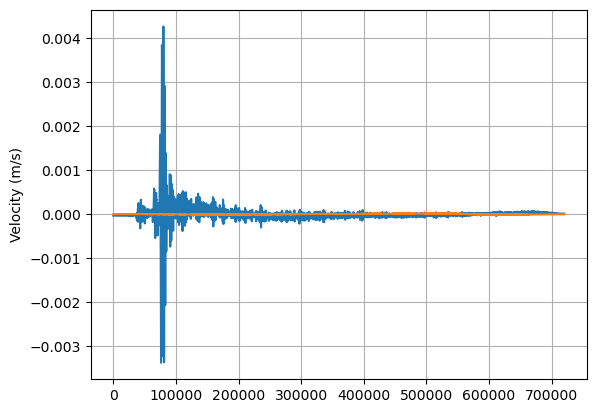

In [3]:
plt.plot(Z[0].data);plt.plot(N[0].data);plt.grid(True);plt.ylabel('Velocity (m/s)')



## Fourier Transform
We use the Scipy Fourier [package](!https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.rfft.html#scipy.fftpack.rfft) to transform the two time series (earthquake and noise).

The Fourier transform is a decomposition of the time series onto a orthonormal basis of cosine and sine functions. The Fourier transform of a time series $f(t)$ (but similarly if the variable is space $x$).

$\hat{F}(f) = \int_{-\infty}^\infty f(t) \exp^{-i2\pi ft} dt$

$\hat{F}(f)$ is the complex Fourier value at frequency $f$. The FOurier transform determines what frequency(ies) dominate the time series.



### Nyquist
The Fourier transform we will use in this class takes a discrete time series of real numbers. The time series is sampled with $N$ samples per seconds. If the time series span $T$ seconds regularly, then the sampling rate of the data $dt=T/N$. The highest frequency that can be resolved in a discrete time series, called the Nyquist frequency, is limited by $dt$:

$F_{Nyq} = \frac{1}{2dt N}$

Effectively, one cannot constrain signals within two time samples from the data.

### Uncertainties
* The discrete Fourier Transform yields an approximation of the FT. The shorter the time series, the least accurate is the FT. This means that the FT on short time windows is less accurate
* The FT assumes (and requires) the periodicity of the series, meaning that the finite/trimmed time series would repeat in time. To enforce this, we  **taper** the time series so that the first and last points are equal (to zero).


In [4]:
from scipy.fftpack import fft, ifft, fftfreq, next_fast_len

npts = Z[0].stats.npts
## FFT the signals
# fill up until 2^N value to speed up the FFT
Nfft = next_fast_len(int(Z[0].data.shape[0])) # this will be an even number
freqVec = fftfreq(Nfft, d=Z[0].stats.delta)[:Nfft//2]
Z.taper(max_percentage=0.05)
Zhat = fft(Z[0].data,n=Nfft)#/np.sqrt(Z[0].stats.npts)


Please see the Obspy documentation to find out about the [taper](!https://docs.obspy.org/master/packages/autogen/obspy.core.trace.Trace.taper.html#supported-methods) function.
Plot the amplitude and phase spectra

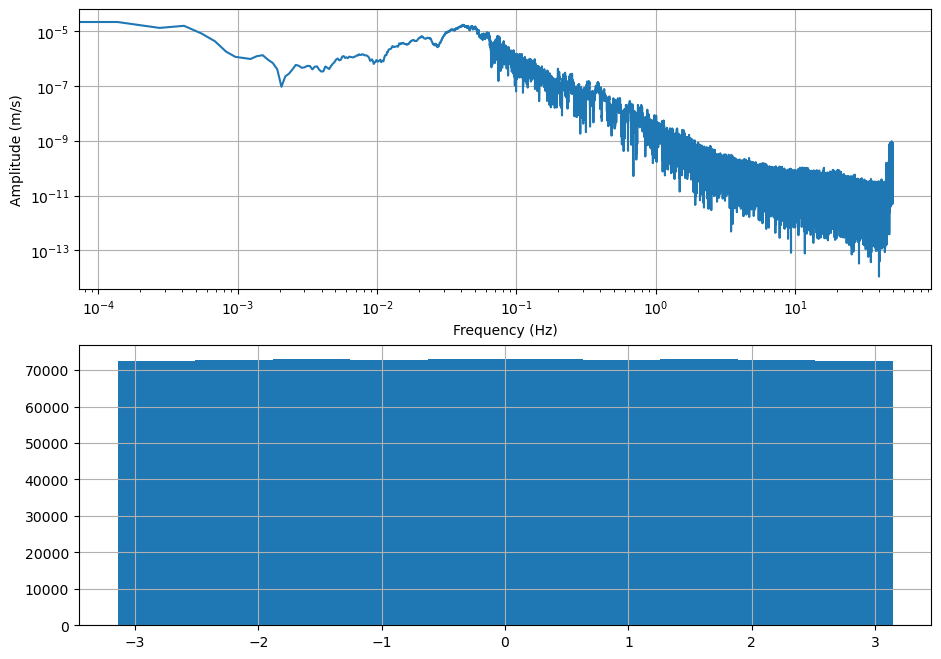

In [5]:
fig,ax=plt.subplots(2,1,figsize=(11,8))
ax[0].plot(freqVec,np.abs(Zhat[:Nfft//2])/Nfft)
ax[0].grid(True)
ax[0].set_xscale('log');ax[0].set_yscale('log')
ax[0].set_xlabel('Frequency (Hz)');ax[0].set_ylabel('Amplitude (m/s)')
ax[1].hist(np.angle(Zhat))
ax[1].grid(True)


You will note above that the phase values are randomly distributed between -pi and pi. We can check it by showing the distribution of the phase and amplitude spectra.


In [ ]:
# your turn. Plot the histograms of the phase and amplitude spectrum
plt.hist(np.log10(np.abs(Zhat[:Nfft//2])/Nfft),100);plt.grid(True)
plt.show()

We can also analyze the spectral characteristics of the noise time series. Below, 
1. compute the Fourier transform
2. plot the phase and amplitude spectra
3. plot the distribution of the phase and amplitude values

In [ ]:
# compute Fourier transform of the noise time series
fig,ax=plt.subplots(2,1,figsize=(11,8))
ax[0].plot(freqVec,np.abs(Zhat[:Nfft//2])/Nfft)
ax[0].grid(True)
ax[0].set_xscale('log');ax[0].set_yscale('log')
ax[0].set_xlabel('Frequency (Hz)');ax[0].set_ylabel('Amplitude (m/s)')
ax[1].hist(np.angle(Zhat))
ax[1].grid(True)


In [7]:
# plot the phase and amplitude spectra
from scipy.fftpack import fft, ifft, fftfreq, next_fast_len

npts = Z[0].stats.npts
## FFT the signals
# fill up until 2^N value to speed up the FFT
Nfft = next_fast_len(int(Z[0].data.shape[0])) # this will be an even number
freqVec = fftfreq(Nfft, d=Z[0].stats.delta)[:Nfft//2]
Z.taper(max_percentage=0.05)
Zhat = fft(Z[0].data,n=Nfft)#/np.sqrt(Z[0].stats.npts)
#NAT=fft(new_noise,n=Nfft)#/np.sqrt(Z[0].stats.npts)
#plt.plot(freqVec, np.abs(NAT[:Nfft//2])

In [ ]:
# Overlay the spectrum of the data and the spectrum of the noise


Overlay their PDFs

In [ ]:
# your turn. Plot the histograms of the phase and amplitude spectrum


You notice that their statistical differences are in the tails of the distributions. Therefore, statistical metrics such as ``mean`` or ``variance`` may not be a discriminatory, but ``kurtosis`` might.

In [ ]:
# Here print mean, median, variance, max, skewness, kurtosis of the log10 of the amplitude spectrum of noise and earthquake waveforms.



### Filtering in the Fourier space

The data may super-impose multiple signals of various frequencies. To remove or extract specific signals that do not overlap in frequencies, we can *filter* the data. 

The filter can be:
* **high pass**: reduce signals at frequencies *lower* than a corner frequency $f_c$, only let the signals *above* $f_c$. Often parameterized in functions as ``hp`` or ``highpass``.
* **low pass**: reduce signals at frequencies *greater* than a cutoff frequency $f_c$, only let the signals *below* that $f_c$. Often parameterized in functions as ``lp`` or ``lowpass``.
* **band pass**: reduce signals at frequencies *lower* than a low corner frequency $f_{c1}$ and at frequencies *greater* than a high corner frequency $f_{c2}>f_{c1}$. Often parameterized as ``bp`` or ``bandpass``.


There exist different types of filters, the most common are ``butterworth`` and ``chebyshev``, but there exist others.

<div>
<img src="filters.png" alt="filters" height=300  />
</div>

Examples of filters illustrated [here](!https://www.ni.com/docs/en-US/bundle/labview/page/lvanlsconcepts/lvac_iir_filter_types.html).

One example is that we want to remove unrealistic signals arising from sensor limitations. Seismometers are rarely sensitive to signals that have periods longer than 100s.

We will use the ``scipy.signal`` module to filter the time series. First we remove the unrealistic signals past 150 s.

In [8]:
# sampling rate of the data:
fs = Z[0].stats.sampling_rate
z=np.asarray(Z[0].data)
n=np.asarray(N[0].data)

We use here a [*butterworth*](!https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html) filter of second order between 1s and 150s. The ``sos`` filter is a *second-order sections*, which are the produc of second-order polynomials to represent the original filters. They are more complex but more stable.

In [25]:

#original
#sos = signal.butter(6,[10,40.], 'bp', fs=fs, output='sos')
sos = signal.butter(6,[1.,10.], 'bp', fs=fs, output='sos')
zf = signal.sosfilt(sos, z)
nf = signal.sosfilt(sos, n)
# the original
t=np.arange(0.,7200.,1./fs)
#t=np.arange(0.,.,1./fs)


In [26]:
z1=signal.sosfiltfilt(sos, z)

Below, make a 2 subplots to show the raw data in the top subplot, and the filtered data in the bottom subplots.

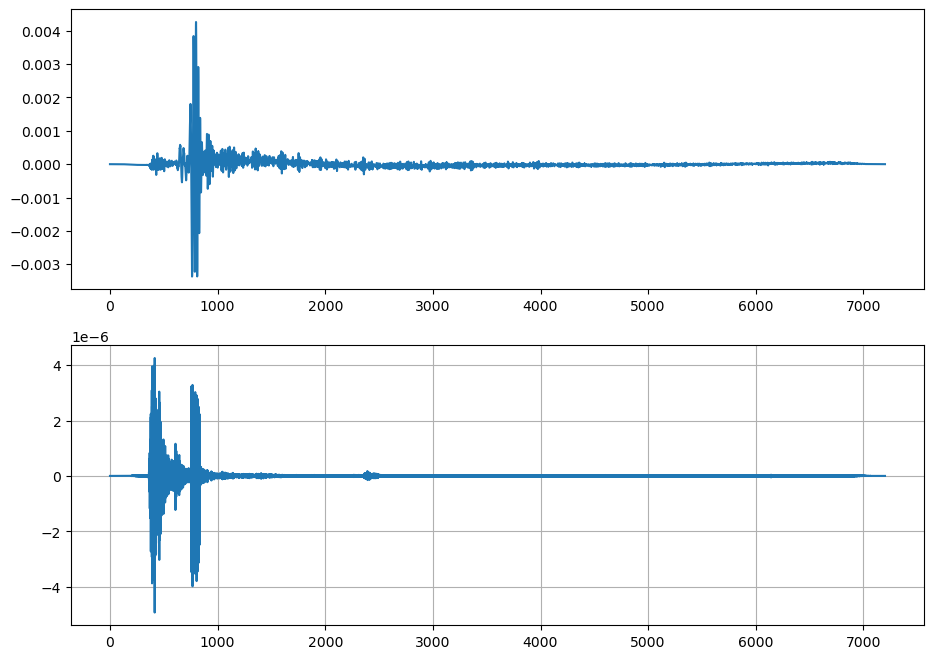

In [27]:
# Type below
#t=np.arange(0.,7200.,1./fs)
fig,ax=plt.subplots(2,1,figsize=(11,8))
ax[0].plot(t,z[:-1]);plt.plot(t,z1[:-1]);plt.grid(True);

Now filter at high frequencies (>10Hz), plot the data, and compare earthquakes and noise signals. 

In [ ]:
# enter below


## Synthetic Noise
Now we could add more noise to the earthquake time series. There are several strategies:

* From time domain, use the ``np.rand[n]`` functions to create a random times series
* From the Fourier domain, use ``np.rand[n]`` functions to create a random *phase spectrum* between -$\pi$ and $\pi$. For the *amplitude spectrum*, you may choose a *white* color, which means that the amplitude spectrum is flat and equal at all frequencies; you may choose a *color* for the spectrum, for instance an amplitude that decays with $1/f$; you may choose the spectrum of the realistic noise, for instance extracted from raw data.


# Use random functions

Below, use the random function to create a synthetic noise. 
1. Create an array of random numbers between -1 and 1 of length the same length as the data Z.
2. Calculate the signal-to-noise ratio, for instance: 

$ SNR = 20 log_{10} (\frac{\max(|signal|)}{\max(|noise)})$

3. Add the synthetic noise with a varying SNR

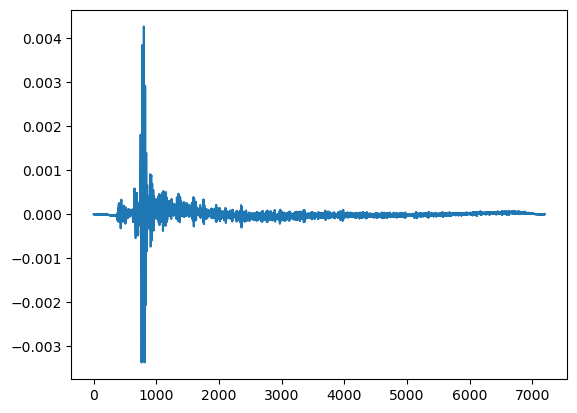

In [32]:
# 1. Create a time series of the synethetic noise
import numpy.random as random
new_noise= random.uniform(-1,1,len(t))
plt.plot(t, z[:-1]+new_noise/1e6)

/srv/conda/envs/notebook/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


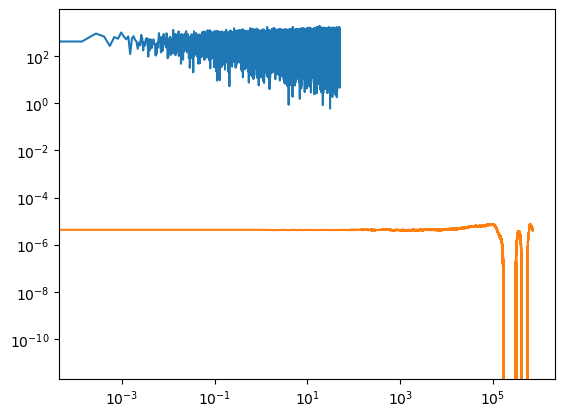

In [55]:
NAT=fft(new_noise,n=Nfft)#/np.sqrt(Z[0].stats.npts)
plt.plot(freqVec, np.abs(NAT[:Nfft//2]))
plt.xscale('log');plt.yscale('log')

Nhat=fft(N[0].data,n=Nfft)#/np.sqrt(Z[0].stats.npts)
newcrap=np.zeros(Nfft)
#loop
for i in range (Nfft//2):
    newcrap[i]=np.abs(Nhat[i])*random.uniform(-np.pi,np.pi)
crap=ifft(newcrap)
plt.plot(crap)

## Cell In [44], line 8
  ##  for i in range (Nfft//2)
##    ^
##IndentationError: unexpected indent
#This error means

In [50]:
#si quiero ver la distribucion de la fase es 
newcrap=fft(crap)
plt.hist(np.angle(newcrap[:Nfft//2]))

NameError: name 'crap' is not defined

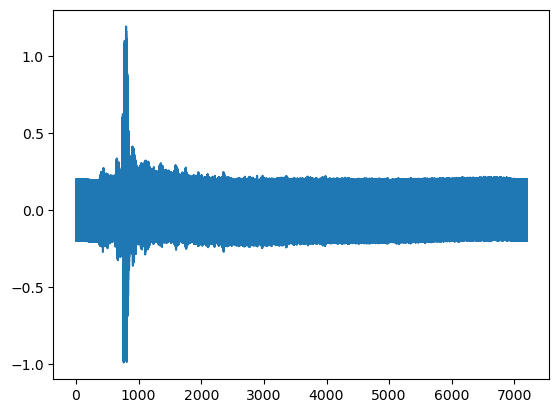

In [37]:
#2. calculate the SNR
SNR=5
plt.plot(t, z[:-1]/np.max(np.abs(z[:-1]))+new_noise/SNR)
SNR=


In [ ]:
# make a loop to add increasing SNRs to the earthquake signal

## 2D Fourier Transforms

The 2D Fourier transform is applied on a 2D matrix. It first applies a 1D Fourier transform to every row of the matrix, then applies a 1D Fourier transform to every column of the intermediate matrix.

2D Fourier transforms can be used to find the Fourier coefficients that dominate the image. This can be used for filtering the data. Another application is to compress the data by selecting several coefficients instead of present most of the image.

We will practice on a DEM.

In [49]:
import wget
import os
import netCDF4 as nc


ModuleNotFoundError: No module named 'wget'

In [46]:
# Download the geological framework
file1 = wget.download("https://www.dropbox.com/s/wdb25puxh3u07dj/NCM_GeologicFrameworkGrids.nc?dl=1") #"./data/NCM_GeologicFrameworkGrids.nc"
# Download the coordinate grids
file2 = wget.download("https://www.dropbox.com/s/i6tv3ug15oe6yhe/NCM_SpatialGrid.nc?dl=1") #"./data/NCM_GeologicFrameworkGrids.nc"

NameError: name 'wget' is not defined

In [ ]:
# move data
os.makedirs('../../data/')
os.replace(file1,'../../data/'+file1)
os.replace(file2,'../../data/'+file2)

In [ ]:
# read data
geology = nc.Dataset('../../data/'+file1)
grid = nc.Dataset('../../data/'+file2)

In [ ]:
# create a grid of latitude and longitude
x = grid['x'][0:4901, 0:3201]
y = grid['y'][0:4901, 0:3201]
elevation = geology['Surface Elevation'][0:4901, 0:3201]
plt.contourf(x, y, elevation)

# recreate the lat long vectors.
minlat,maxlat = min(grid['Latitude vector'][:]),max(grid['Latitude vector'][:])
minlon,maxlon = min(grid['Longitude vector'][:]),max(grid['Longitude vector'][:])
xlat = np.linspace(minlat,maxlat,3201)
xlon = np.linspace(minlon,maxlon,4901)

Consider ``elevation`` as a 2D data set. We can perform a 2D transform, which will give us a spectrum in the spatial dimension.

In [ ]:
from scipy.fftpack import fft2, fftfreq,fftshift, ifft2
import matplotlib.cm as cm
Zel = fft2(elevation)



# make a vector of distances. Here I will ignore the curvature and spatial projection.
# make the wavenumber frequency vector: 
Rlon = (xlon-np.min(xlon))*111.25  # convert degrees to kms
drlon = Rlon[1]-Rlon[0]
print("this is about the spatial sampling of the model ",drlon," km")
klon = (fftfreq( 4901//2 , drlon  ))


Rlat = (xlat-np.min(xlat))*111.25  # convert degrees to kms
drlat = Rlat[1]-Rlat[0]
print("this is about the spatial sampling of the model ",drlat," km")
klat = (fftfreq( 3201//2 , drlat  ))

# amplitude of the DEM
plt.imshow(fftshift(np.log10(np.abs(Zel)/Zel.size)),vmin=-3, vmax=-1, cmap='RdYlBu',extent=[-1,1,-1,1])
plt.title('2D FT of elevation')
x_label_list = ['-1/3 km$^{-1}$','0','1/3  km$^{-1}$']
plt.xticks([-0.5,0,0.5])
plt.yticks([-0.5,0,0.5])
plt.show()

Now we will filter or compress by taking the largest Fourier coefficients of the image.

In [ ]:
# Sort the Fourier coefficients
Zsort = np.sort(np.abs(np.abs(Zel).reshape(-1)))

In [ ]:
print(len(Zsort))
print(Zsort.shape)

In [ ]:
from IPython import display
import time
for keep in (0.1,0.05,0.01):
    display.clear_output(wait=True)
    thresh = Zsort[int(np.floor( (1-keep)*len(Zsort) ))]
    ind = np.abs(Zel)>thresh
    Atlow = Zel * ind # here we zero out the matrix
    # Here we count the number of non-zeros in the matrix
    print("We are keeping up to %f the number of Fourier coefficients" % keep)
    Alow = ifft2(Atlow).real
    plt.contourf(x, y, Alow)
    time.sleep(1)

Now we will compare the original 2D data set with the Fourier compressed data


In [ ]:
keep=0.01
thresh = Zsort[int(np.floor( (1-keep)*len(Zsort) ))]
ind = np.abs(Zel)>thresh
Atlow = Zel * ind # here we zero out the matrix
# Here we count the number of non-zeros in the matrix
print("We are keeping up to %f the number of Fourier coefficients" % keep)
Alow = ifft2(Atlow).real


fig,ax=plt.subplots(1,2,figsize=(8,8),sharex=True)
ax[0].contourf(x, y, elevation);ax[0].set_title('Original data')
ax[0].axis('scaled')
ax[1].contourf(x, y, Alow);ax[1].set_title('Compressed data')
ax[1].axis('scaled')

### Wavelet transform

The wavelet transform projects the time series onto a 2D space of *time* and *scale* axis. The *scale* is a representation of the frequency scale of the data. The waveletn transforms uses a series of functions called *wavelets* to linearly decompose the signals. Unlike the *sine* functions of the Fourier transform, the *wavelets* have finite durations and are localized in time:

 <div>
<img src="Wavelet-Out1.jpeg" alt="wavelet" height=100  />
</div>

Image from this [article](!https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/).

There exist many canonical wavelet families. The difference between families are typically their shape, compactness, and smoothness. Typically, one chooses one family for the specific time series. Wavelets have finite energy and zero mean.

The time-scale representation of of a time series is a *scaleogram*. *scales* can be converted to pseudo frequencies: If $f_c$ is the central frequency of the wavelet and the scale is $a$, then the pseuo-frequency is $f_a = f_c/a$.


 <div>
<img src="wavelet_families.png" alt="wavelet" height=300  />
</div>

Image from this [article](!https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/).

The wavelet transform becomes:

$\hat{F}(a,b) = \frac{1}{\sqrt{a}} \int_{-\infty}^\infty f(t) \bar{\Psi} (\frac{t-b}{a}) dt$

where $\bar{\Psi}$ is the mother wavelet scaled by a factor of $a$ and translated/shifted by $b$. The wavelet transform is scaled by the continuous and "infinite number of values" of $a$ and $b$ are continuous. The *Discrete Wavelet Transform* is the wavelet transform performed on a finite number of scales and shifts.

In [ ]:
import scipy.signal as signal


t = np.arange(0,(Tend-Tstart)+Z[0].stats.delta,Z[0].stats.delta)
fs=1/Z[0].stats.delta

# use the number of scales
w = 10.

# relate scales with frequencies
# freq = np.linspace(0, fs/2, 100)
freq = np.logspace(-1, np.log10(fs/2), 100)
widths = w*fs / (2*freq*np.pi)


cwtm = signal.cwt(z, signal.morlet2, widths, w=w)

Calculating the time-frequency representation of large time series 

In [ ]:

# cwtmatr = signal.cwt(z, signal.morlet, widths)
plt.imshow(np.log10(np.abs(cwtm)), extent=[t.min(),t.max(),freq.min(),freq.max()], cmap='plasma', aspect='auto',
           vmax=6, vmin=-0.5,origin='lower')
# plt.yscale('log')
# plt.set_x
plt.show()

TF transforms take computational time in the workflow, let's compare:

In [ ]:
%timeit cwtm = signal.cwt(z, signal.morlet2, widths, w=w)
%timeit f, t, Zxx = stft(n, fs=100, nperseg=nperseg,noverlap=200)
